In [2]:
import pandas as pd
import anndata
import numpy
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Parameter

In [3]:
delta_dmr_rate_cutoff = 0.3

In [4]:
# Parameters
delta_dmr_rate_cutoff = 0.3

## Load Data

In [ ]:
dmr_hits = anndata.read_h5ad('RelatedClusterAndDMR.hypo_hits.h5ad')
dmr_hits = pd.DataFrame(dmr_hits.X.astype(bool).todense(), index=dmr_hits.obs_names, columns=dmr_hits.var_names)
dmr_hits.head()

In [ ]:
dmr_rate = pd.read_msgpack('RelatedClusterAndDMR.mcg_rate.msg')
dmr_rate.head()

In [ ]:
dmg = pd.read_msgpack('RelatedDMG.msg')
dmg['cluster_from'] = dmg['cluster_from'].str.replace(' ', '_')
dmg['cluster_to'] = dmg['cluster_to'].str.replace(' ', '_')
print(dmg.shape)
dmg.head()

In [7]:
corr = pd.read_msgpack('RelatedCorr.msg')
corr.head()

,DMR,Gene,Corr,chrom,DMR_to_gene_dist
0,Subchr1_96,ENSMUSG00000104017.1,0.366926,chr1,-306195.0
1,Subchr1_96,ENSMUSG00000089699.1,0.498140,chr1,-394994.0
2,Subchr1_96,ENSMUSG00000103201.1,0.436467,chr1,-442914.0
3,Subchr1_135,ENSMUSG00000103201.1,0.355481,chr1,-418849.0
4,Subchr1_176,ENSMUSG00000104017.1,0.512181,chr1,-258484.0


In [8]:
# subset the dmr and dmg based on corr
dmr_hits = dmr_hits.loc[corr['DMR'].unique()].copy()
dmr_rate = dmr_rate.loc[corr['DMR'].unique()].copy()
dmg = dmg[dmg['gene_id'].isin(corr['Gene'].unique())].copy()

In [9]:
dmg[['cluster_from', 'cluster_to']].drop_duplicates().shape

(272, 2)

## prepare DMR pairwise

In [10]:
pairwise_dmr_index = {}
n = 0
for _, (cluster_from, cluster_to) in dmg[['cluster_from', 'cluster_to']].drop_duplicates().iterrows():
    n += 1
    if n % 1000 == 0:
        print(n)
    # cluster_from is hypo, cluster_to is hyper
    rate_delta = (dmr_rate[cluster_to] - dmr_rate[cluster_from]) > delta_dmr_rate_cutoff
    # cluster_to is not hypo, cluster_from is hypo, and rate_delta > delta_dmr_rate_cutoff
    total_judge = (~dmr_hits[cluster_to]) & dmr_hits[cluster_from] & rate_delta
    
    # remaining dmr is sig hypo in cluster_from and hyper in cluster_to
    pairwise_dmr_index[(cluster_from, cluster_to)] = total_judge[total_judge].index

## final DMG DMR for pairwise cluster

In [11]:
related_genes = pd.read_csv('related_dmgs.txt', header=None, index_col=0).index
related_genes.name = 'gene_id'
# create a table to store all related genes
gene_dmr_counts = pd.DataFrame([], index=related_genes)

In [12]:
with pd.HDFStore('FinalDMGDMR.h5') as f:
    n = 0
    for (cluster_from, cluster_to), cluster_pair_df in dmg.groupby(
        ['cluster_from', 'cluster_to']):
        n += 1
        if n % 500 == 0:
            print(n)
        # first get related dmr and dmg separately
        cluster_pair_related_dmr = pairwise_dmr_index[(cluster_from, cluster_to)]
        cluster_pair_related_gene = cluster_pair_df['gene_id'].unique()
        
        # use them to filter corr
        cluster_pair_related_corr = corr[
            corr['DMR'].isin(cluster_pair_related_dmr)
            & corr['Gene'].isin(cluster_pair_related_gene)]
        
        # then use remained dmr and dmg as final list
        # the remaining DMR DMG is:
        # - sig hypo in one clsuter compare to another
        # - have sig correlateion
        cluster_pair_related_dmr = pd.Series(cluster_pair_related_corr['DMR'].unique())
        cluster_pair_related_gene = pd.Series(cluster_pair_related_corr['Gene'].unique())
        # print(cluster_from, cluster_to, cluster_pair_related_dmr.size, cluster_pair_related_gene.size)
        f[f'{cluster_from}/{cluster_to}/DMR'] = cluster_pair_related_dmr
        f[f'{cluster_from}/{cluster_to}/Gene'] = cluster_pair_related_gene
        f[f'{cluster_from}/{cluster_to}/Corr'] = pd.Series(cluster_pair_related_corr.index)
        
        gene_counts = cluster_pair_related_corr['Gene'].value_counts()
        gene_dmr_counts[(cluster_from, cluster_to)] = gene_counts.reindex(
            related_genes).fillna(0).astype(int)

## Save DMG DMR counts table

In [13]:
gene_pos = (gene_dmr_counts > 0).sum(axis=1)
gene_dmr_counts = gene_dmr_counts[gene_pos > 0].copy()
gene_dmr_counts.to_msgpack('DMRCounts_for_DMG_in_cluster_pairs.msg')
gene_dmr_counts.shape

(8439, 272)

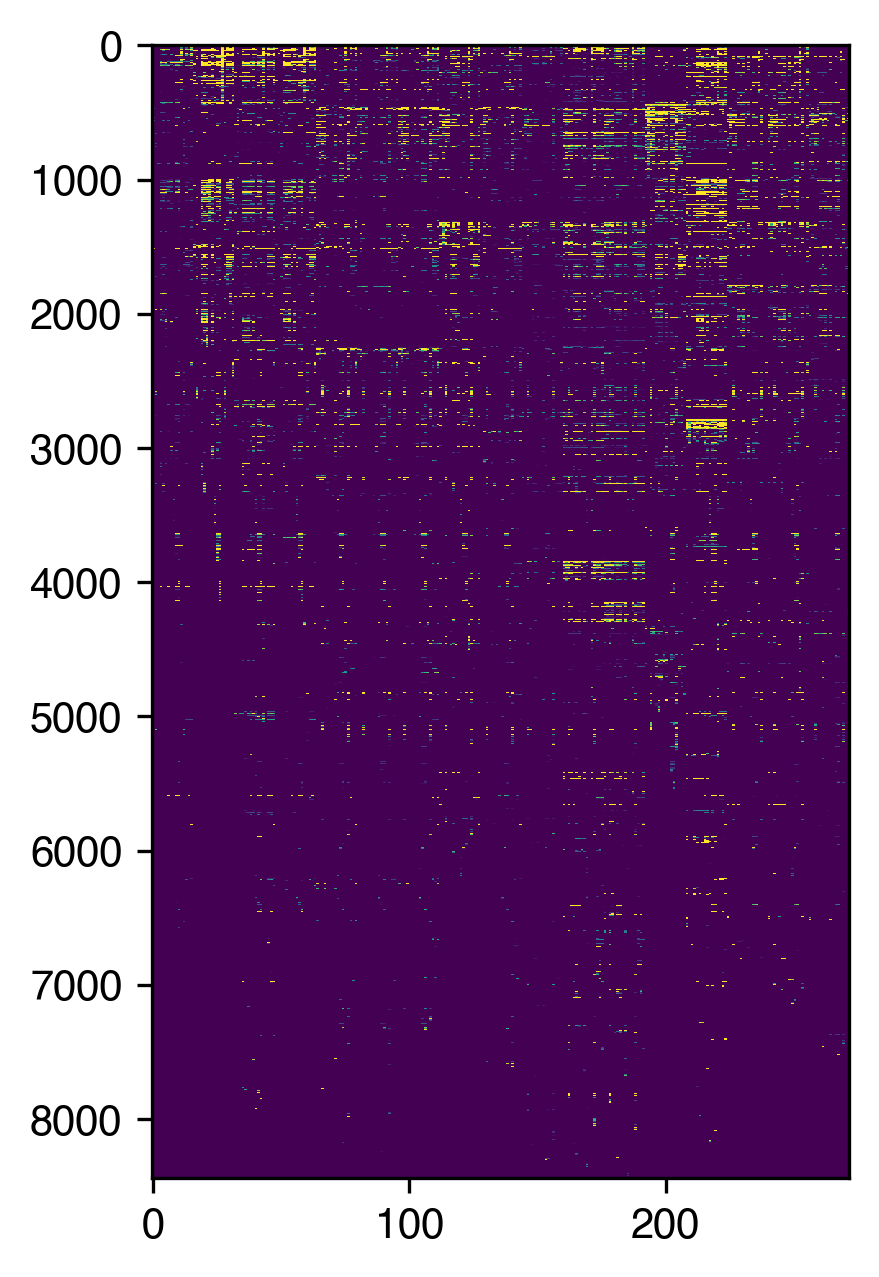

In [15]:
plt.figure(figsize=(3, 5), dpi=300)
plt.imshow(gene_dmr_counts.values, vmin=3, vmax=30, aspect='auto')